In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import array
from scipy.io import savemat
import scipy.io

import argparse
import numpy as np
from skimage import io, util
from sklearn.feature_extraction import image
from sklearn import preprocessing
from ksvd import ApproximateKSVD

In [5]:
blm = np.fromfile('nu_hat_blm.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
orig = np.fromfile('nu.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
fz = np.fromfile('fz.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
z = np.fromfile('z.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]


### Patch representation and KSVD

In [6]:
def _ksvd(img):

    global patch_shape
    
    patch_size = (4, 4)
    patches = image.extract_patches_2d(img, patch_size)

    patch_shape = patches.shape
    print(patches.shape)  # (6, 10, 1, 512, 512, 3)

    signals = patches.reshape(patches.shape[0], -1)

    mean = np.mean(signals, axis=1)[:, np.newaxis]



    signals -= mean

    aksvd = ApproximateKSVD(n_components=20)

    D = aksvd.fit(signals[:10000])

    dictionary = D.components_

    A = aksvd.transform(signals)




    weights  = (A!=0).sum(axis=0)/(A!=0).sum()

    delta =5
    weights_matrix = np.diag(weights*delta+1)

    D_prime = np.matmul(weights_matrix,dictionary)
    reduced = A.dot(D_prime) + mean

    reduced_img = image.reconstruct_from_patches_2d(
        reduced.reshape(patches.shape), img.shape)
    return(A, D_prime, reduced,reduced_img)

    

In [7]:
A,D_prime,reduced,reduced_img = _ksvd(fz)

_,_,_,reduced_img_z = _ksvd(z)

(9409, 4, 4)
(9409, 4, 4)


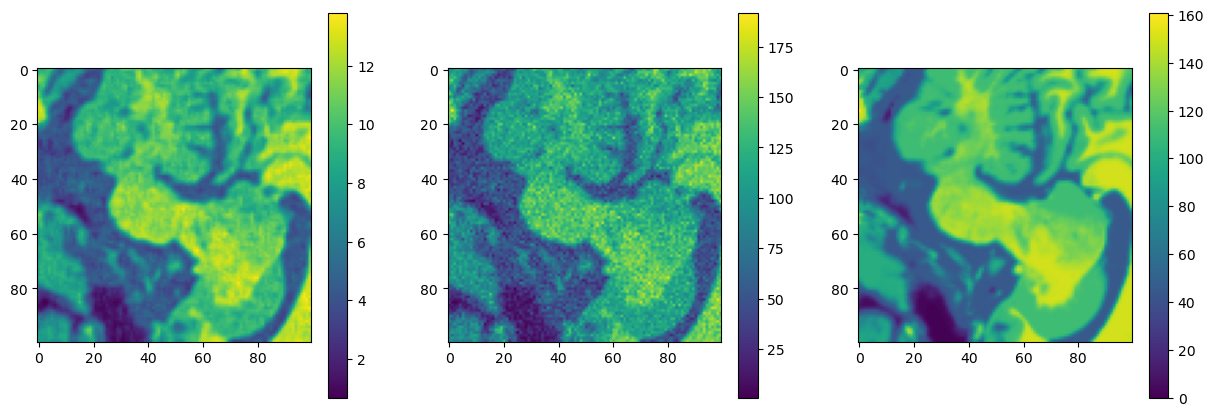

In [8]:
plt.figure(figsize =(15,5))

plt.subplot(131)
plt.imshow(reduced_img)
plt.colorbar()

plt.subplot(132)
plt.imshow(z)
plt.colorbar()


plt.subplot(133)
plt.imshow(orig)
plt.colorbar()

####  Здесь обозначение словарей (проще было список делать) как в статье I, M,CSS,SS

In [13]:
I = {}
for i,row in enumerate(reduced):
    I[i] = []
    for j in range(D_prime.shape[0]):
        if A[i,j]!=0:
            I[i].append(j)

    

In [14]:
M={}
for i in I:
    if len(I[i])==0:
        M[i] = None
    else:
        M[i]= abs(A[I[i]]).argmax()
        

In [15]:

import tqdm

In [16]:
CSS={}
for i in tqdm.tqdm(I):
    CSS[i] = []
    if len(I[i])==0:
        continue
    for j in M:
        if M[j] in I[i]:
            CSS[i].append(j)

100%|██████████████████████████████████████| 9409/9409 [00:17<00:00, 524.21it/s]


In [17]:
SS = {}
for i in tqdm.tqdm(CSS):
    SS[i] = [reduced[i]]
    if len(CSS[i])==0:
        continue
    for j in CSS[i]:
        #print(np.linalg.norm(reduced[i]-reduced[j])/np.linalg.norm(reduced[i]))
        if np.linalg.norm(reduced[i]-reduced[j])/np.linalg.norm(reduced[i])<0.07:
            SS[i].append(reduced[j])
    

100%|██████████████████████████████████████| 9409/9409 [00:28<00:00, 335.68it/s]


####  Здесь должен быть svd из схожих патчей, но лучше работает среднее

In [18]:
y_hat = reduced.copy()

for i in SS:
    u, s, vh = scipy.linalg.svd(SS[i], full_matrices=False)# Remove sigma values below threshold (250)

    s_cleaned = np.array([s[i] if i<20 else 0 for i in range(len(s))])# Calculate A' = U * Σ (cleaned) * V

    img_denoised = np.array(np.dot(u * s_cleaned, vh), dtype=int)
    #y_hat[i] = np.mean(SS[i],axis=0)
    y_hat[i] = np.mean(img_denoised,axis=0)

In [19]:
# for i in SS:
#     print(len(SS[i]))

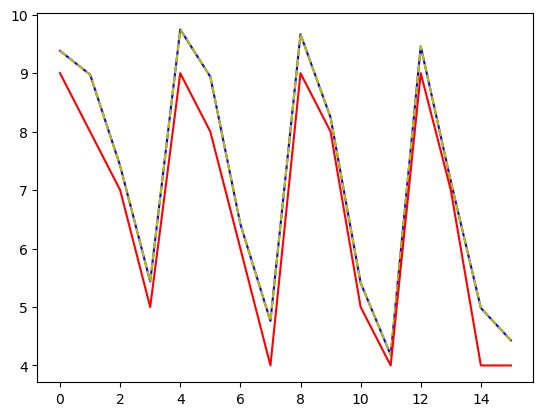

In [20]:
# for i in SS[1]:
#     plt.plot(i,color='r')
# plt.plot(reduced[1],'g--')
l= 100
for i in SS[l]:
    plt.plot(i,color='b')
plt.plot(reduced[l],'y--')
plt.plot(y_hat[l],'r')

In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# def psnr(img1, img2):
#     mse = np.mean((img1 - img2) ** 2)
#     if mse == 0:
#         return 100
#     PIXEL_MAX = 255.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [22]:
reduced_hat = image.reconstruct_from_patches_2d(y_hat.reshape(patch_shape), z.shape)

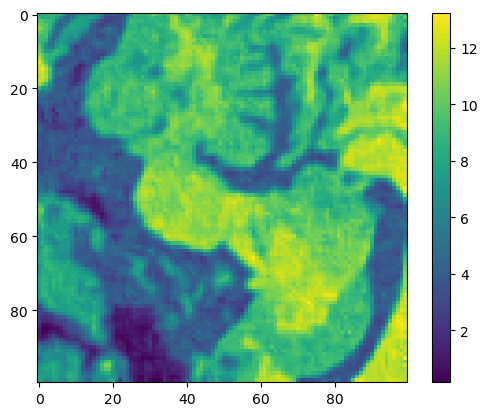

In [23]:
plt.imshow(reduced_hat)
plt.colorbar()

####  часть, которая задействует матлаб и делает обратный vst 

In [223]:
with open(f'all', 'rb') as _f:
    all_pics= pickle.load(_f)

In [271]:
res_ksvd={} 
res_ksvd['fz'] = reduced_img 

savemat('transformed_ksvd.mat',res_ksvd)


res ={}
res['fz'] = all_pics[ 'averaging']
savemat('transformed.mat',res)

In [274]:
all_vst = {}
all_vst['reference'] = all_pics['reference']
all_vst['distorted'] = distorted

all_vst['vst'] = vst

all_vst['ksvd'] = ksvd
all_vst['nonlocal'] = non_local

all_vst['svd'] = svd

all_vst['averaging'] = averaging




In [256]:
all_pics

{'reference': array([[ 9.3,  9.2,  9.7, ..., 12.6, 11.9, 11.4],
        [10.1, 10.2, 10.8, ..., 12.4, 11.8, 11.4],
        [10.8, 11.1, 11. , ..., 12.1, 11.5, 11.2],
        ...,
        [ 9.3,  9.4,  9.4, ..., 14.9, 14.9, 14.8],
        [ 9.5,  9.5,  9.3, ..., 15. , 14.9, 14.8],
        [ 9.6,  9.7,  9.5, ..., 15. , 15. , 14.9]]),
 'distorted': array([[10.72405194,  8.61624396, 10.99104412, ..., 12.51082881,
         10.20145436, 12.55398305],
        [ 9.66064175, 10.7313938 , 11.32074627, ..., 11.07479585,
          9.31210688, 10.56859779],
        [10.91711465, 12.54149992, 11.39707508, ..., 11.4812206 ,
         12.8008645 ,  9.80626726],
        ...,
        [ 9.69417343,  6.18573917,  8.88373592, ..., 13.00065499,
         15.42817273, 16.28079582],
        [ 8.34816454, 10.67218117,  9.03618348, ..., 14.65076763,
         15.99224108, 13.32548016],
        [ 9.5365338 ,  8.68423255,  8.05615052, ..., 14.86049633,
         14.80851633, 14.06794677]]),
 'vst': array([[ 9.0849909

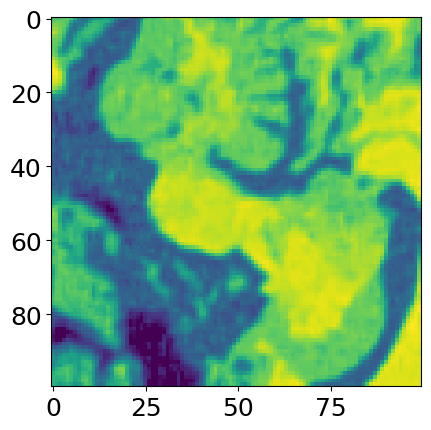

In [273]:
plt.imshow(averaging)

In [240]:
distorted==svd

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [246]:
ksvd= np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T

In [272]:
averaging = np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T

In [239]:
distorted = np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T

In [236]:
svd = np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T

In [234]:
non_local = np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T

In [120]:
# nu_hat_res= np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(181,217).T#.reshape(100,100).T
# nu_hat_ksvd= np.fromfile('nu_hat_ksvd.bin', dtype=np.float64).reshape(181,217).T#.reshape(100,100).T


nu_hat_res= np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T
nu_hat_ksvd= np.fromfile('nu_hat_ksvd.bin', dtype=np.float64).reshape(100,100).T

In [275]:
with open(r"all_vst.pickle", "wb") as output_file:
    pickle.dump(all_vst, output_file)

In [199]:
with open(r"results_7.pickle", "wb") as output_file:
    pickle.dump(result_array_7, output_file)

In [ ]:
names = ['Original', 'Noise 7%', 'KSVD', 'EDSR', 'BM4D', 'NLSD']


In [195]:
result_array_7 = [orig, z, nu_hat_ksvd,pd_lr,blm, sait, nu_hat_res ]
metrics = [(round(psnr(pic,orig,data_range = 200),3),
          round(ssim(pic,orig,data_range = 200),2)) for pic in result_array]
names_7 = ['Original', 'Noise 7%', 'KSVD', 'EDSR', 'BM4D','RDN' 'NLSD']
metrics[0] = (1,1)


In [196]:
with open(f'results_7.pickle', 'rb') as _f:
    res = pickle.load(_f)

In [200]:
len(res)

7

In [204]:
with open(f'out_for_kirill.pt', 'rb') as _f:
    sait = pickle.load(_f)[::2,::2][50:150,:100]
    sait = sait/sait.max()*255

In [205]:
sait.max()

255.0

In [260]:
pd_lr

array([[113.20053 ,  86.19781 ,  94.93329 , ..., 137.4206  , 107.651764,
        131.45663 ],
       [100.714   ,  92.51645 , 119.34121 , ..., 121.68562 ,  82.7418  ,
        107.31916 ],
       [ 96.09265 , 127.04098 , 114.54114 , ..., 101.274155, 135.37738 ,
         98.055466],
       ...,
       [115.58328 ,  49.154453,  88.65153 , ..., 131.34404 , 139.85835 ,
        168.12065 ],
       [ 82.67941 , 108.442215,  93.04764 , ..., 135.66797 , 166.50388 ,
        138.55821 ],
       [ 81.03645 ,  86.5843  ,  83.8059  , ..., 146.65822 , 157.3894  ,
        129.98793 ]], dtype=float32)

In [293]:

with open(f'out_2.pt', 'rb') as _f:
    pd_lr = pickle.load(_f)[::2,::2][50:150,:100]/3

In [291]:
pd_lr

array([[111.03583 ,  88.74402 ,  93.16149 , ..., 137.35443 , 109.37903 ,
        130.11314 ],
       [103.83032 ,  90.82894 , 119.789406, ..., 121.28498 ,  80.21295 ,
        110.62495 ],
       [ 96.25768 , 126.94074 , 115.6574  , ...,  99.398254, 139.21056 ,
         92.296104],
       ...,
       [116.49679 ,  47.04912 ,  90.35767 , ..., 132.68782 , 135.3306  ,
        169.42583 ],
       [ 82.40896 , 108.91442 ,  92.96536 , ..., 135.02165 , 168.64362 ,
        139.37323 ],
       [ 81.692406,  85.79084 ,  85.583015, ..., 146.58653 , 154.0711  ,
        131.69453 ]], dtype=float32)

In [265]:

with open(f'results_corner_avg.pkl', 'rb') as _f:
    avg = pickle.load(_f)

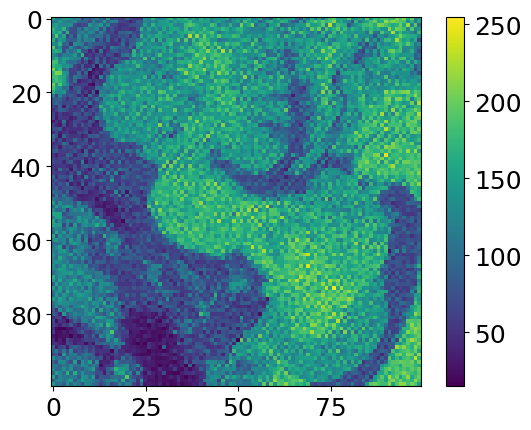

In [208]:
plt.imshow(sait)
plt.colorbar()

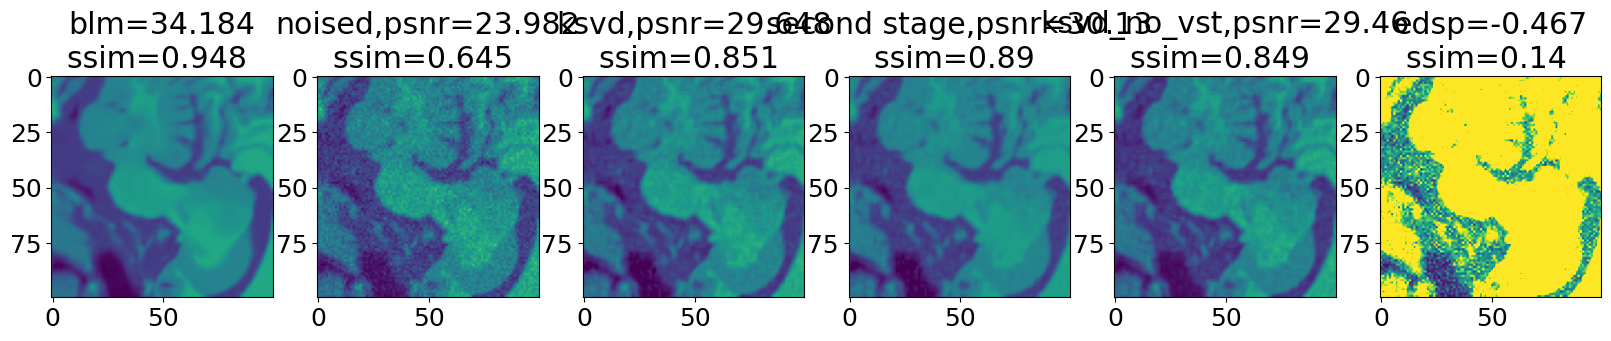

In [281]:
plt.figure(figsize =(20,7))

plt.subplot(261)
# plt.title('Original')
# plt.imshow(orig,vmax=250)
plt.title(f'blm={round(psnr(blm,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(blm,orig,data_range = 200),3)} ')

plt.imshow(blm,vmax=250)



plt.subplot(262)
plt.title(f'noised,psnr={round(psnr(z,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(z,orig,data_range = 200),3)} ')

plt.imshow(z,vmax=250)



plt.subplot(263)

plt.title(f'ksvd,psnr={round(psnr(nu_hat_ksvd,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(nu_hat_ksvd,orig,data_range = 200),3)} ')
plt.imshow(nu_hat_ksvd,vmax=250)

plt.subplot(264)

plt.title(f'second stage,psnr={round(psnr(nu_hat_res,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(nu_hat_res,orig,data_range = 200),3)} ')

plt.imshow(nu_hat_res,vmax=250)



plt.subplot(265)

plt.title(f'ksvd_no_vst,psnr={round(psnr(reduced_img_z,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(reduced_img_z,orig,data_range = 200),3)} ')

plt.imshow(reduced_img_z,vmax=250)


plt.subplot(266)

plt.title(f'edsp={round(psnr(pd_lr,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(pd_lr,orig,data_range = 200),3)} ')

plt.imshow(pd_lr,vmax=250)


In [282]:
len(result_array)

6

In [294]:
result_array = [orig, z, nu_hat_ksvd,pd_lr,blm, sait ]
metrics = [(round(psnr(pic,orig,data_range = 200),3),
          round(ssim(pic,orig,data_range = 200),2)) for pic in result_array]
names = ['Original', 'Noise 7%', 'KSVD', 'EDSR', 'BM4D','RDN']
metrics[0] = (1,1)


In [295]:
len(names)

6

In [296]:

plt.rcParams.update({'font.size': 18})

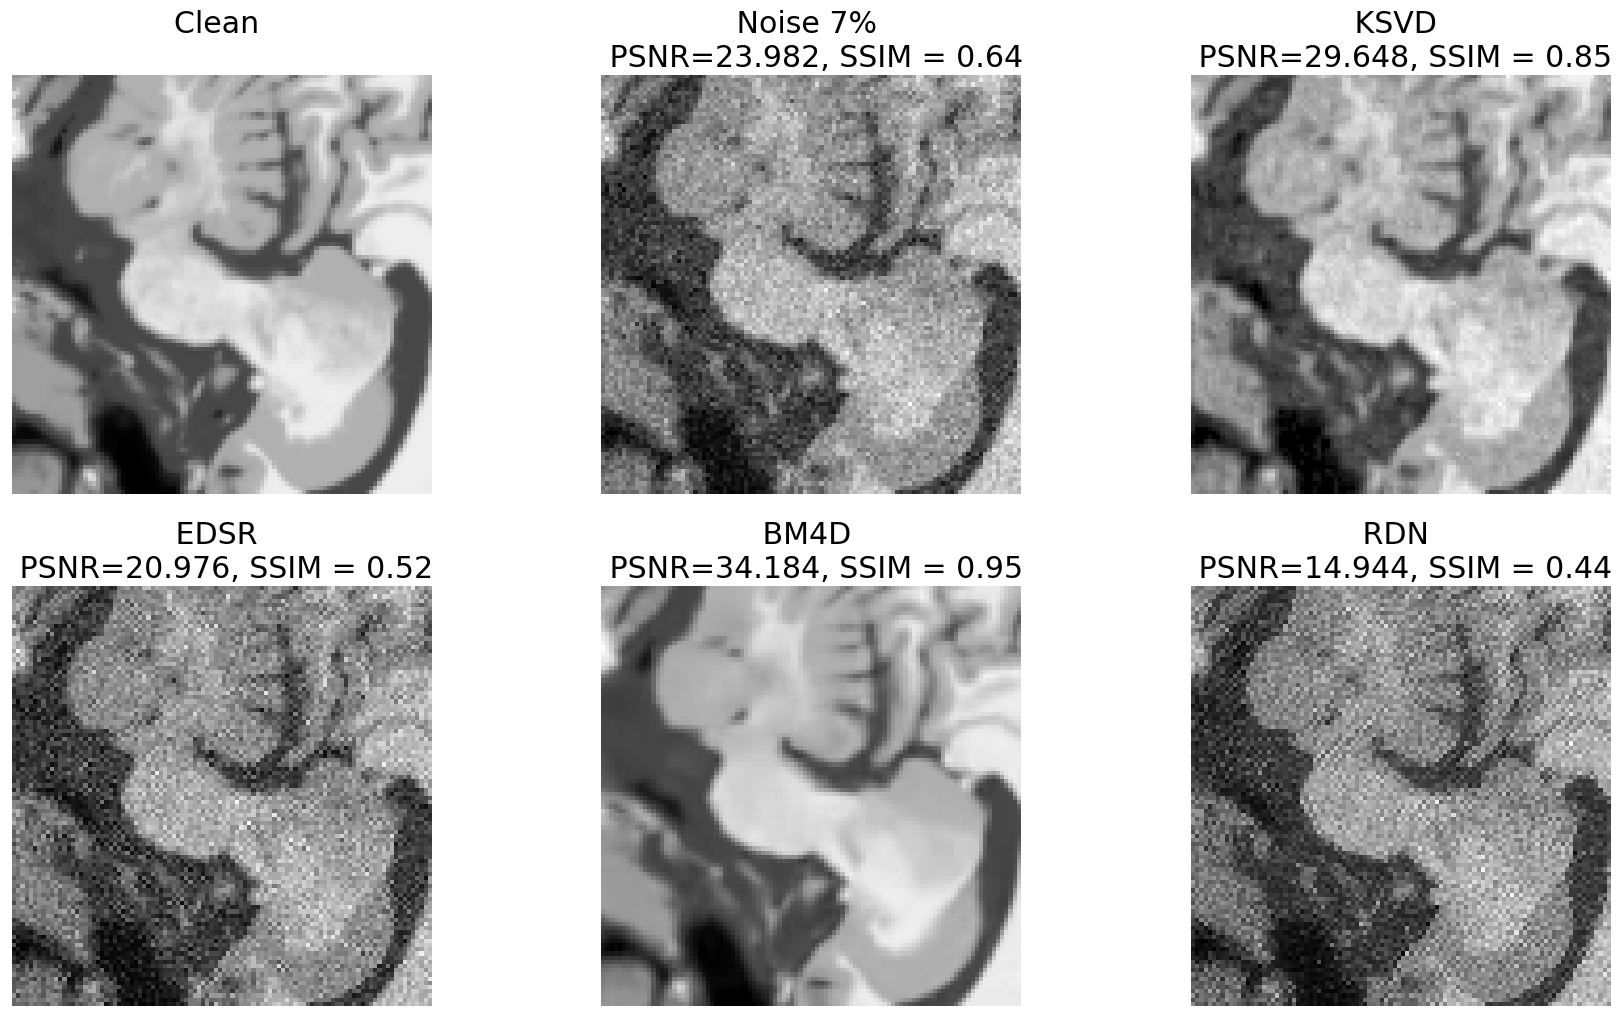

In [297]:
fig,ax = fig, axs = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
for i,pic in enumerate( result_array[:]):
    if i>0:
        ax[i // 3,i%3].set_title(f' {names[i]}  \n PSNR={metrics[i][0]}, SSIM = {metrics[i][1]}')
    else:
        ax[i // 3,i%3].set_title('Clean \n')
    ax[i // 3,i%3].imshow(pic,cmap='gray')
    ax[i // 3,i%3].axis('off')
    
plt.tight_layout()
